# Practice 1: Convolutional Neural Network - Deep Learning course

*   Alejandro Dopico Castro (alejandro.dopico2@udc.es).
*   Ana Xiangning Pereira Ezquerro (ana.ezquerro@udc.es).

In [1]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy
from logging import ERROR
tf.get_logger().setLevel(ERROR)
import warnings, os
warnings.filterwarnings("ignore")
from utils import *
from models import *
from typing import List, Tuple
model_accuracies: List[Tuple[str, int]] = []

# global variables 
IMG_SIZE = 100
BATCH_SIZE = 258
base_dir = 'animals/'
model_dir = 'results/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    

2024-03-05 16:15:34.675092: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 16:15:34.706054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 16:15:34.706080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 16:15:34.706906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 16:15:34.712128: I tensorflow/core/platform/cpu_feature_guar

## Table of Contents 

1. [Dataset preprocessing](#exercise-1-dataset-preprocessing)
2. [Custom Convolutional Models](#exercise-2-custom-convolutional-models)
    - [Simple Model](#21-simple-model)
    - [Mid Complex Model](#22-mid-complex-model)
    - [Model with residual connections](#23-model-with-residual-connections)
    - [Inception block](#24-inception-block)
    - [What happens if we add Data Augmentation?](#25-what-if-we-add-data-augmentation)
    - [Custom models comparison](#26-custom-models-comparison)
3. [Pretrained Models](#exercise-3-pretrained-models)
    - [Fine-tuning](#31-fine-tuning)
    - [Feature Extraction](#32-feature-extraction)
    - [Partial Fine-tuning](#33-partial-fine-tuning)
    - [Comparison between pretrained approaches](#34-comparison-between-pretrained-approaches)
4. [Comparison](#4-results-and-comparison)

## Exercise 1. Dataset preprocessing

We decided to use for the image resolution $80\times 80$ for retrieving similar results than considering higher resolutions with the simpler architectures. The batch size is adapted to fit the GPU capabilities of the local machine. We used the original validation set for evaluation a split a 15% of the data for validation. All the input images were normalized to fit the range $[0,1]$ with the [Rescaling layer](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/).

In [2]:
train_dataset, val_dataset, test_dataset = load_data(base_dir, IMG_SIZE, BATCH_SIZE)

Found 13474 files belonging to 5 classes.
Using 11453 files for training.
Using 2021 files for validation.


2024-03-05 16:15:36.797126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-03-05 16:15:36.797704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22435 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Found 1497 files belonging to 5 classes.


## Exercise 2. Custom Convolutional Models

For this exercise, we prepared four different convolutional architectures with increasing complexity and regularization methods to tackle the animal classification problem: ([1](#21-simple-model)) a simple linear approach with 2 convolutional layers interleaved with max-pooling, ([2](#22-mid-complex-model)) a more complex convolutional-linear model with 3 blocks of paired convolutions and max-poolings, ([3](#23-model-with-residual-connections)) a convolutional architecture based on residual connections ([He et al., 2015](https://arxiv.org/abs/1512.03385)), ([4](#24-inception-block)) the integration of the Inception block ([Szegedy et al., 2014](https://arxiv.org/abs/1409.4842)). We used the validation split to tune each hyperparameter configuration (although not all experiments are included in this notebook to facilitate the readibility) and applied some regularization methods learnt in previous practical lessons to avoid overfitting.

### 2.1. Simple Model

In [3]:
simple_model = SimpleModel(num_classes=5)
optimizer = Adam(learning_rate=1e-3)
simple_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
simple_model_history = train_model(simple_model, train_dataset, val_dataset, epochs=20, path=model_dir, batch_size=BATCH_SIZE, verbose=1).history
print(
    f"Final loss: training -> {simple_model_history['loss'][-1]:.2f}, validation -> {simple_model_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {simple_model_history['acc'][-1]:.2f}, \
        validation -> {simple_model_history['val_acc'][-1]:.2f}"
)
plot_history(simple_model_history, ['loss', 'acc'], name='Simple Model')

Epoch 1/20


2024-03-05 16:15:39.505995: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-05 16:15:40.061026: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0ea1de25e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 16:15:40.061048: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-05 16:15:40.061051: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-05 16:15:40.065526: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709651740.174400   37314 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 [==============================] - 9s 126ms/step - loss: 2.1052 - acc: 0.4702 - val_loss: 0.9632 - val_acc: 0.6462 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - 5s 95ms/step - loss: 0.8826 - acc: 0.6800 - val_loss: 0.8715 - val_acc: 0.6764 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - 5s 94ms/step - loss: 0.7917 - acc: 0.7104 - val_loss: 0.7764 - val_acc: 0.6997 - lr: 0.0010
Epoch 4/20
45/45 [==============================] - 5s 95ms/step - loss: 0.7080 - acc: 0.7422 - val_loss: 0.7640 - val_acc: 0.7091 - lr: 0.0010
Epoch 5/20
45/45 [==============================] - 5s 94ms/step - loss: 0.6520 - acc: 0.7668 - val_loss: 0.7360 - val_acc: 0.7229 - lr: 0.0010
Epoch 6/20
45/45 [==============================] - 5s 94ms/step - loss: 0.5958 - acc: 0.7874 - val_loss: 0.7276 - val_acc: 0.7269 - lr: 0.0010
Epoch 7/20
45/45 [==============================] - 5s 92ms/step - loss: 0.5674 - acc: 0.7976 - val_loss: 0.7629 - val_acc: 0.7110 - lr: 0.0010
Ep

In [4]:
test_loss, test_accuracy = simple_model.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
print(simple_model.summary())
model_accuracies.append(("SimpleModel", test_accuracy))

6/6 [==============================] - 1s 73ms/step - loss: 0.6535 - acc: 0.7615
Model evaluated: Test Loss-> 0.6535041928291321, Test Accuracy -> 76.15%
Model: "SimpleModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  896       
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0 (unused)
 g2D)                            

### 2.2 Mid Complex Model

In [5]:
mid_model = MidModel(num_classes=5)
optimizer = Adam(learning_rate=1e-3)
mid_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
mid_model_history = train_model(
    mid_model, 
    train_dataset, 
    val_dataset, 
    epochs=30, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    path=model_dir, 
    lr_patience=5, 
    val_patience=10
).history
print(
    f"Final loss: training -> {mid_model_history['loss'][-1]:.2f}, validation -> {mid_model_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {mid_model_history['acc'][-1]:.2f}, validation -> {mid_model_history['val_acc'][-1]:.2f}"
)
plot_history(mid_model_history, ['loss', 'acc'], name='Mid Complex Model')

Epoch 1/30


2024-03-05 16:17:28.662586: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inMidModel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


45/45 [==============================] - 15s 156ms/step - loss: 1.3804 - acc: 0.4140 - val_loss: 0.9400 - val_acc: 0.6467 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - 6s 100ms/step - loss: 0.8527 - acc: 0.6690 - val_loss: 0.7428 - val_acc: 0.7041 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - 6s 100ms/step - loss: 0.7073 - acc: 0.7262 - val_loss: 0.6787 - val_acc: 0.7506 - lr: 0.0010
Epoch 4/30
45/45 [==============================] - 6s 100ms/step - loss: 0.5940 - acc: 0.7636 - val_loss: 0.5951 - val_acc: 0.7665 - lr: 0.0010
Epoch 5/30
45/45 [==============================] - 6s 100ms/step - loss: 0.5315 - acc: 0.7901 - val_loss: 0.5451 - val_acc: 0.7867 - lr: 0.0010
Epoch 6/30
45/45 [==============================] - 6s 100ms/step - loss: 0.4767 - acc: 0.8116 - val_loss: 0.5186 - val_acc: 0.8031 - lr: 0.0010
Epoch 7/30
45/45 [==============================] - 6s 99ms/step - loss: 0.4347 - acc: 0.8284 - val_loss: 0.6208 - val_acc: 0.7566 - lr: 0.0

In [6]:
test_loss, test_accuracy = mid_model.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
mid_model.summary()

6/6 [==============================] - 1s 105ms/step - loss: 0.5078 - acc: 0.8737
Model evaluated: Test Loss-> 0.507785975933075, Test Accuracy -> 87.37%
Model: "MidModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           multiple                  896       
                                                                 
 conv2d_3 (Conv2D)           multiple                  9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           multiple                  0         
                                    

### 2.3 Model with residual connections

In [7]:
resnet = CustomResNet(num_classes=5)
optimizer = Adam(learning_rate=1e-3)
resnet.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
resnet_history = train_model(
    resnet,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10,
).history
print(
    f"Final loss: training -> {resnet_history['loss'][-1]:.2f}, validation -> {resnet_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet_history['acc'][-1]:.2f}, validation -> {resnet_history['val_acc'][-1]:.2f}"
)
plot_history(resnet_history, ['loss', 'acc'], name='Custom ResNet')

Epoch 1/50


45/45 [==============================] - 18s 189ms/step - loss: 1.5763 - acc: 0.4199 - val_loss: 18.5657 - val_acc: 0.2088 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - 6s 110ms/step - loss: 0.7890 - acc: 0.6873 - val_loss: 16.5690 - val_acc: 0.2088 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - 6s 109ms/step - loss: 0.5756 - acc: 0.7731 - val_loss: 4.4556 - val_acc: 0.2578 - lr: 0.0010
Epoch 4/50
45/45 [==============================] - 5s 98ms/step - loss: 0.4693 - acc: 0.8169 - val_loss: 4.8484 - val_acc: 0.2499 - lr: 0.0010
Epoch 5/50
45/45 [==============================] - 6s 109ms/step - loss: 0.4091 - acc: 0.8419 - val_loss: 3.9115 - val_acc: 0.2895 - lr: 0.0010
Epoch 6/50
45/45 [==============================] - 6s 109ms/step - loss: 0.3503 - acc: 0.8647 - val_loss: 2.7380 - val_acc: 0.3196 - lr: 0.0010
Epoch 7/50
45/45 [==============================] - 6s 99ms/step - loss: 0.2635 - acc: 0.8996 - val_loss: 3.1095 - val_acc: 0.3696 - lr: 0.

In [8]:
test_loss, test_accuracy = resnet.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
model_accuracies.append(("ResNet", test_accuracy))
resnet.summary()

6/6 [==============================] - 1s 159ms/step - loss: 0.5323 - acc: 0.8864
Model evaluated: Test Loss-> 0.5322756767272949, Test Accuracy -> 88.64%
Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     multiple                  0         
                                                                 
 zero_padding2d (ZeroPaddin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           multiple                  9472      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  multiple

### 2.4. Inception block

In [9]:
inception = InceptionModel(num_classes=5, num_blocks=3, n_filters=[(32, 32, 64, 64) for _ in range(3)], kernel_size=7, dropout=0)
optimizer = Adam(learning_rate=1e-4)
inception.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
inception_history = train_model(
    inception,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {inception_history['loss'][-1]:.2f}, validation -> {inception_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {inception_history['acc'][-1]:.2f}, validation -> {inception_history['val_acc'][-1]:.2f}"
)
plot_history(inception_history, ['loss', 'acc'], name='Inception Model')

Epoch 1/50


45/45 [==============================] - 124s 1s/step - loss: 1.1250 - acc: 0.6259 - val_loss: 1.6565 - val_acc: 0.3508 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 20s 409ms/step - loss: 0.5521 - acc: 0.7983 - val_loss: 2.5751 - val_acc: 0.2187 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 20s 411ms/step - loss: 0.3685 - acc: 0.8621 - val_loss: 2.2349 - val_acc: 0.2222 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 20s 412ms/step - loss: 0.2660 - acc: 0.8994 - val_loss: 1.9170 - val_acc: 0.2632 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 20s 412ms/step - loss: 0.1759 - acc: 0.9412 - val_loss: 1.9310 - val_acc: 0.3469 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 20s 424ms/step - loss: 0.1125 - acc: 0.9657 - val_loss: 1.3809 - val_acc: 0.5082 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 20s 412ms/step - loss: 0.0651 - acc: 0.9829 - val_loss: 1.460

In [10]:
test_loss, test_accuracy = inception.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss -> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
model_accuracies.append(("Inception", test_accuracy))
inception.summary()

6/6 [==============================] - 8s 1s/step - loss: 0.5818 - acc: 0.8517
Model evaluated: Test Loss -> 0.5818189978599548, Test Accuracy -> 85.17%
Model: "InceptionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     multiple                  0         
                                                                 
 inception (Inception)       multiple                  83872     
                                                                 
 inception_1 (Inception)     multiple                  95584     
                                                                 
 inception_2 (Inception)     multiple                  95584     
                                                                 
 conv2d_35 (Conv2D)          multiple                  602176    
                                                                 
 conv2d_43 (Conv2D)          mu

### 2.5 What if we add Data Augmentation?

In [11]:
from keras.models import Sequential
resnet_data_aug = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.GaussianNoise(0.01),
    CustomResNet(num_classes=5)
], name='ResNetAug')

resnet_data_aug.compile(optimizer="adam", loss="sparse_categorical_crossentropy",  metrics=[SparseCategoricalAccuracy('acc')])
resnet_data_aug_history = train_model(
    resnet_data_aug,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10,
).history

print(
    f"Final loss: training -> {resnet_data_aug_history['loss'][-1]:.2f}, validation -> {resnet_data_aug_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet_data_aug_history['acc'][-1]:.2f}, validation -> {resnet_data_aug_history['val_acc'][-1]:.2f}"
)
plot_history(resnet_data_aug_history, ['loss', 'acc'], name='Augmented ResNet Model')

Epoch 1/50


45/45 [==============================] - 12s 114ms/step - loss: 1.7256 - acc: 0.3396 - val_loss: 2.2404 - val_acc: 0.2286 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - 6s 100ms/step - loss: 1.1306 - acc: 0.5394 - val_loss: 4.6759 - val_acc: 0.2088 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - 6s 99ms/step - loss: 0.8359 - acc: 0.6741 - val_loss: 6.2913 - val_acc: 0.2271 - lr: 0.0010
Epoch 4/50
45/45 [==============================] - 6s 99ms/step - loss: 0.7048 - acc: 0.7247 - val_loss: 6.5943 - val_acc: 0.2583 - lr: 0.0010
Epoch 5/50
45/45 [==============================] - 6s 99ms/step - loss: 0.5933 - acc: 0.7655 - val_loss: 6.7220 - val_acc: 0.2128 - lr: 0.0010
Epoch 6/50
45/45 [==============================] - 6s 99ms/step - loss: 0.5610 - acc: 0.7806 - val_loss: 3.8321 - val_acc: 0.3073 - lr: 0.0010
Epoch 7/50
45/45 [==============================] - 6s 100ms/step - loss: 0.4365 - acc: 0.8288 - val_loss: 3.1325 - val_acc: 0.3246 - lr: 2.0000

In [12]:
test_loss, test_accuracy = resnet_data_aug.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
model_accuracies.append(("AugmentedResNet", test_accuracy))
resnet_data_aug.summary()

6/6 [==============================] - 0s 18ms/step - loss: 0.3095 - acc: 0.9031
Model evaluated: Test Loss-> 0.3095219135284424, Test Accuracy -> 90.31%
Model: "ResNetAug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 100, 100, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 100, 100, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 100, 100, 3)       0         
                                                                 
 gaussian_noise (GaussianNo  (None, 100, 100, 3)       0         
 ise)                                                            
                                                                 
 ResNet (CustomResNet)       (None,

### 2.6. Custom models comparison

In the next output we have displayed the accuracy performance of each custom model in the train and test set to analyze the overfitting behavior. 

In [29]:
models = [simple_model, mid_model, inception, resnet, resnet_data_aug]
comparison(models, (train_dataset, test_dataset))

The left figure shows each model performance in the train (blue) and test (orange) sets. We see that for all models the performance is considerably better in the train set (99%) than in the evaluation samples (75-85%), proving the network is learning the train set characteristics instead of generalizing image information for the given task. The right figure shows the disadvantage of using larger networks with more complex connections (Inception), inducing a higher difference between the train and test set. Additionally, we see the impact of regularizing the network via data augmentation (ResNetAug). The result is the smaller difference between the train and test set.

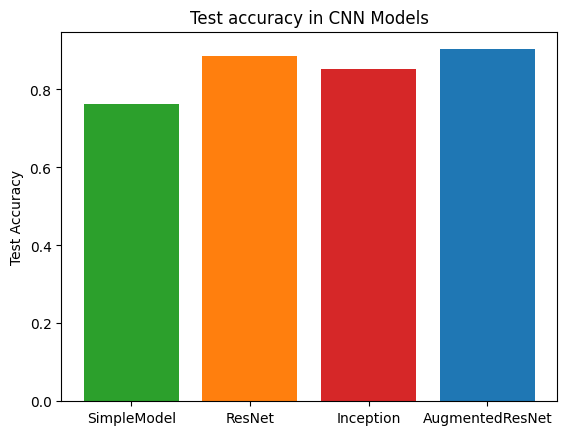

In [30]:
fig, ax = plt.subplots()
models = [name for name, _ in model_accuracies]
accuracies = [accuracy for _, accuracy in model_accuracies]
bar_colors = ["tab:green", "tab:orange", "tab:red", "tab:blue", 'tab:pink']
ax.bar(models, accuracies, label=models, color=bar_colors)

ax.set_ylabel("Test Accuracy")
ax.set_title("Test accuracy in CNN Models")
plt.show()

## Exercise 3. Pretrained models

For this exercise we conducted experiments with three pretrained models available in the [Keras Applications website](https://keras.io/api/applications/) pretrained with ImageNet dataset: [ResNet-50](https://keras.io/api/applications/resnet/#resnet50v2-function) ([He et al., 2016](https://aruexiv.org/abs/1603.05027)), [MobileNet-V2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) ([Sandler et al.,, 2018](https://arxiv.org/abs/1801.04381)) and [EfficientNet-B0](https://keras.io/api/applications/efficientnet/#efficientnetb0-function) ([Tan & Le, 2019](https://arxiv.org/abs/1905.11946)). Our first approach fine-tunes the complete architecture with the animals dataset. The second round uses the same pretrained models to project the hidden features of each image and train a simple feed-forward network classifier to output the vector of probabilities. The lsat approaches explores defreezing only the last 10 layers of each architecture to test if maintaining a large ratio of trainable weights does not impact in the overal performance.

### 3.1. Fine-tuning



#### ResNet-50 V2

In [31]:
resnet50 = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='resnet', name='ResNet50V2')
optimizer = Adam(learning_rate=1e-4)
resnet50.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
resnet50_history = train_model(
    resnet50,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {resnet50_history['loss'][-1]:.2f}, validation -> {resnet50_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet50_history['acc'][-1]:.2f}, validation -> {resnet50_history['val_acc'][-1]:.2f}"
)
plot_history(resnet50_history, ['loss', 'acc'], name=f'{resnet50.name} Model')
test_loss, test_accuracy = resnet50.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
resnet50.summary()

Epoch 1/50
45/45 [==============================] - 37s 321ms/step - loss: 0.5299 - acc: 0.8256 - val_loss: 1.2553 - val_acc: 0.8540 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 10s 192ms/step - loss: 0.0471 - acc: 0.9857 - val_loss: 0.4805 - val_acc: 0.8971 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 10s 196ms/step - loss: 0.0065 - acc: 0.9991 - val_loss: 0.4081 - val_acc: 0.9104 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 10s 196ms/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.3618 - val_acc: 0.9134 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 10s 192ms/step - loss: 0.0020 - acc: 0.9997 - val_loss: 0.3430 - val_acc: 0.9179 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 10s 192ms/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.3319 - val_acc: 0.9193 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 8s 147ms/step - loss: 0.0013 - acc: 0.9997 - val

#### MobileNet V2

In [32]:
mobile = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='mobile', name='MobileNetV2')
optimizer = Adam(learning_rate=1e-4)
mobile.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
mobile_history = train_model(
    mobile,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {mobile_history['loss'][-1]:.2f}, validation -> {mobile_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {mobile_history['acc'][-1]:.2f}, validation -> {mobile_history['val_acc'][-1]:.2f}"
)
plot_history(mobile_history, ['loss', 'acc'], name=f'{mobile.name} Model')
test_loss, test_accuracy = mobile.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
mobile.summary()

Epoch 1/50
45/45 [==============================] - 28s 197ms/step - loss: 0.6446 - acc: 0.8187 - val_loss: 0.6537 - val_acc: 0.8803 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 6s 107ms/step - loss: 0.0674 - acc: 0.9796 - val_loss: 0.6822 - val_acc: 0.8916 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 6s 108ms/step - loss: 0.0186 - acc: 0.9962 - val_loss: 0.7930 - val_acc: 0.8921 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 6s 106ms/step - loss: 0.0077 - acc: 0.9990 - val_loss: 0.7744 - val_acc: 0.8941 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 6s 107ms/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.7461 - val_acc: 0.9090 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 6s 108ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.7437 - val_acc: 0.9070 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 6s 108ms/step - loss: 0.0019 - acc: 0.9998 - val_loss

#### EfficientNet B0

In [33]:
efficient = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='efficient', name='EfficientNetB0')
optimizer = Adam(learning_rate=1e-4)
efficient.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
efficient_history = train_model(
    efficient,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {efficient_history['loss'][-1]:.2f}, validation -> {efficient_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {efficient_history['acc'][-1]:.2f}, validation -> {efficient_history['val_acc'][-1]:.2f}"
)
plot_history(efficient_history, ['loss', 'acc'], name=f'{efficient.name} Model')
test_loss, test_accuracy = efficient.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
efficient.summary()

Epoch 1/50


2024-03-05 16:52:11.014578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetB0/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


45/45 [==============================] - 32s 202ms/step - loss: 0.5718 - acc: 0.7885 - val_loss: 2.0307 - val_acc: 0.1851 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 8s 152ms/step - loss: 0.1616 - acc: 0.9421 - val_loss: 2.5246 - val_acc: 0.1851 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 8s 152ms/step - loss: 0.0746 - acc: 0.9756 - val_loss: 2.1531 - val_acc: 0.2172 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 8s 152ms/step - loss: 0.0433 - acc: 0.9881 - val_loss: 2.7200 - val_acc: 0.1559 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 8s 152ms/step - loss: 0.0314 - acc: 0.9907 - val_loss: 2.9792 - val_acc: 0.1415 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 8s 152ms/step - loss: 0.0218 - acc: 0.9944 - val_loss: 3.2152 - val_acc: 0.1781 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 8s 152ms/step - loss: 0.0172 - acc: 0.9951 - val_loss: 3.6048 - 

### 3.2. Feature extraction


#### ResNet-50 V2

In [35]:
resnet50_feat = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='resnet', defreeze = 0, name='ResNet50V2-feat')
optimizer = Adam(learning_rate=1e-4)
resnet50_feat.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
resnet50_feat_history = train_model(
    resnet50_feat,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {resnet50_feat_history['loss'][-1]:.2f}, validation -> {resnet50_feat_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet50_feat_history['acc'][-1]:.2f}, validation -> {resnet50_feat_history['val_acc'][-1]:.2f}"
)
plot_history(resnet50_feat_history, ['loss', 'acc'], name=f'{resnet50_feat.name} Model')
test_loss, test_accuracy = resnet50_feat.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
resnet50_feat.summary()

Epoch 1/50


45/45 [==============================] - 10s 145ms/step - loss: 0.6647 - acc: 0.8696 - val_loss: 0.3630 - val_acc: 0.9040 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 7s 133ms/step - loss: 0.0843 - acc: 0.9736 - val_loss: 0.3018 - val_acc: 0.9179 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 7s 132ms/step - loss: 0.0220 - acc: 0.9952 - val_loss: 0.3002 - val_acc: 0.9184 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0070 - acc: 0.9996 - val_loss: 0.3003 - val_acc: 0.9198 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 6s 100ms/step - loss: 0.0039 - acc: 0.9997 - val_loss: 0.3086 - val_acc: 0.9189 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0029 - acc: 0.9997 - val_loss: 0.3146 - val_acc: 0.9193 - lr: 1.0000e-04
Epoch 7/50
24/45 [===============>..............] - ETA: 2s - loss: 0.0034 - acc: 0.9994

#### MobileNet V2

In [ ]:
mobile_feat = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='mobile', defreeze = 0, name='MobileNetV2-feat')
optimizer = Adam(learning_rate=1e-4)
mobile_feat.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
mobile_feat_history = train_model(
    mobile_feat,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {mobile_feat_history['loss'][-1]:.2f}, validation -> {mobile_feat_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {mobile_feat_history['acc'][-1]:.2f}, validation -> {mobile_feat_history['val_acc'][-1]:.2f}"
)
plot_history(mobile_feat_history, ['loss', 'acc'], name=f'{mobile_feat.name} Model')
test_loss, test_accuracy = mobile_feat.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
mobile_feat.summary()

Epoch 1/50
45/45 [==============================] - 8s 122ms/step - loss: 1.3626 - acc: 0.8283 - val_loss: 0.2125 - val_acc: 0.9159 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 6s 114ms/step - loss: 0.1486 - acc: 0.9414 - val_loss: 0.1745 - val_acc: 0.9347 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 6s 114ms/step - loss: 0.0890 - acc: 0.9714 - val_loss: 0.1699 - val_acc: 0.9377 - lr: 1.0000e-04
Epoch 4/50
10/45 [=====>........................] - ETA: 2s - loss: 0.0650 - acc: 0.9798

KeyboardInterrupt: 

#### EfficientNet-B0

In [ ]:
efficient_feat = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='efficient', defreeze = 0, name='EfficientNetB0-feat')
optimizer = Adam(learning_rate=1e-4)
efficient_feat.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
efficient_feat_history = train_model(
    efficient_feat,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {efficient_feat_history['loss'][-1]:.2f}, validation -> {efficient_feat_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {efficient_feat_history['acc'][-1]:.2f}, validation -> {efficient_feat_history['val_acc'][-1]:.2f}"
)
plot_history(efficient_feat_history, ['loss', 'acc'], name=f'{efficient_feat.name} Model')
test_loss, test_accuracy = efficient_feat.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
efficient_feat.summary()

### 3.3. Partial fine-tuning


#### ResNet-50 V2

In [ ]:
resnet50_defreeze = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='resnet', defreeze = 10, name='ResNet50V2-defreeze')
optimizer = Adam(learning_rate=1e-4)
resnet50_defreeze.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
resnet50_defreeze_history = train_model(
    resnet50_defreeze,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {resnet50_defreeze_history['loss'][-1]:.2f}, validation -> {resnet50_defreeze_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet50_defreeze_history['acc'][-1]:.2f}, validation -> {resnet50_defreeze_history['val_acc'][-1]:.2f}"
)
plot_history(resnet50_defreeze_history, ['loss', 'acc'], name=f'{resnet50_defreeze.name} Model')
test_loss, test_accuracy = resnet50_defreeze.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
resnet50_defreeze.summary()

Epoch 1/50
45/45 [==============================] - 9s 139ms/step - loss: 0.8317 - acc: 0.8541 - val_loss: 0.3832 - val_acc: 0.9005 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 7s 133ms/step - loss: 0.0989 - acc: 0.9710 - val_loss: 0.3034 - val_acc: 0.9099 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 6s 100ms/step - loss: 0.0240 - acc: 0.9962 - val_loss: 0.3049 - val_acc: 0.9114 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0096 - acc: 0.9992 - val_loss: 0.3131 - val_acc: 0.9099 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0055 - acc: 0.9996 - val_loss: 0.3213 - val_acc: 0.9134 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0040 - acc: 0.9996 - val_loss: 0.3288 - val_acc: 0.9149 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0032 - acc: 0.9997 - val_loss: 0.3

#### MobileNet V2

In [ ]:
mobile_defreeze = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='mobile', defreeze = 10, name='MobileNetV2-defreeze')
optimizer = Adam(learning_rate=1e-4)
mobile_defreeze.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
mobile_defreeze_history = train_model(
    mobile_defreeze,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {mobile_defreeze_history['loss'][-1]:.2f}, validation -> {mobile_defreeze_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {mobile_defreeze_history['acc'][-1]:.2f}, validation -> {mobile_defreeze_history['val_acc'][-1]:.2f}"
)
plot_history(mobile_defreeze_history, ['loss', 'acc'], name=f'{mobile_defreeze.name} Model')
test_loss, test_accuracy = mobile_defreeze.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
mobile_defreeze.summary()

Epoch 1/50
45/45 [==============================] - 8s 122ms/step - loss: 1.3626 - acc: 0.8283 - val_loss: 0.2125 - val_acc: 0.9159 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 6s 114ms/step - loss: 0.1486 - acc: 0.9414 - val_loss: 0.1745 - val_acc: 0.9347 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 6s 114ms/step - loss: 0.0890 - acc: 0.9714 - val_loss: 0.1699 - val_acc: 0.9377 - lr: 1.0000e-04
Epoch 4/50
10/45 [=====>........................] - ETA: 2s - loss: 0.0650 - acc: 0.9798

KeyboardInterrupt: 

#### EfficientNet-B0

In [ ]:
efficient_defreeze = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='efficient', defreeze = 10, name='EfficientNetB0-defreeze')
optimizer = Adam(learning_rate=1e-4)
efficient_defreeze.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
efficient_defreeze_history = train_model(
    efficient_defreeze,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {efficient_defreeze_history['loss'][-1]:.2f}, validation -> {efficient_defreeze_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {efficient_defreeze_history['acc'][-1]:.2f}, validation -> {efficient_defreeze_history['val_acc'][-1]:.2f}"
)
plot_history(efficient_defreeze_history, ['loss', 'acc'], name=f'{efficient_defreeze.name} Model')
test_loss, test_accuracy = efficient_defreeze.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
efficient_defreeze.summary()

### 3.4. Comparison between pretrained approaches 

## 4. Results and comparison